# Sparse matrices and iterative methods

## Sparse format

Large matrices whose entries are mostly zeros are typically called *sparse*. They can be stored more efficiently than "dense" or full matrices, but must explicitly be constructed as a sparse type. 

In [6]:
using LinearAlgebra, SparseArrays
A = sprandn(10000,10000,0.0004);
varinfo(Main,r"A")

| name |        size | summary                                    |
|:---- | -----------:|:------------------------------------------ |
| A    | 704.258 KiB | 10000×10000 SparseMatrixCSC{Float64,Int64} |


The equivalent full (or "dense") matrix requires almost 800 MB of storage. 

In [8]:
Afull = Matrix(A);
varinfo(Main,r"Afull")

| name  |        size | summary                      |
|:----- | -----------:|:---------------------------- |
| Afull | 762.939 MiB | 10000×10000 Array{Float64,2} |


Two common ways to inspect a sparse matrix are `nnz`, the number of nonzeros, and `spy`, which shows the locations of the nonzeros.

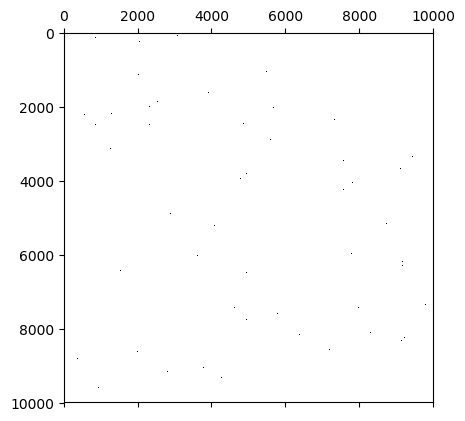

40062

In [11]:
using PyPlot
spy(Afull)
nnz(A)

You can use `findnz` to get all the nonzero elements and their locations.

In [12]:
i,j,s = findnz(A)

([1320, 1538, 2436, 7027, 9332, 7611, 7930, 8739, 1436, 4117  …  8824, 1434, 6663, 1646, 3118, 5728, 450, 616, 5436, 5915], [1, 1, 1, 1, 1, 2, 2, 2, 3, 3  …  9997, 9998, 9998, 9999, 9999, 9999, 10000, 10000, 10000, 10000], [2.18876, 0.477163, 0.188315, -1.23346, 0.825988, 1.17751, 1.62751, 0.497596, -1.87862, 1.62097  …  0.929337, 0.188515, 0.541002, -0.654597, 0.5352, 0.0494514, -0.806043, -0.124555, -0.0678588, 0.364484])

In [14]:
(s[1],A[i[1],j[1]])

(2.1887648208781596, 2.1887648208781596)

## Making sparse matrices

If the matrix is not too big, you can construct it as usual and then use `sparse` to convert it. This is rarely the best option for real work, though. 

You can also use the `sparse` function to construct a sparse matrix, essentially as the inverse operation of `findnz` above.

In [15]:
AA = sparse(i,j,s,10000,10000)

10000×10000 SparseMatrixCSC{Float64,Int64} with 40062 stored entries:
  [1320 ,     1]  =  2.18876
  [1538 ,     1]  =  0.477163
  [2436 ,     1]  =  0.188315
  [7027 ,     1]  =  -1.23346
  [9332 ,     1]  =  0.825988
  [7611 ,     2]  =  1.17751
  [7930 ,     2]  =  1.62751
  [8739 ,     2]  =  0.497596
  [1436 ,     3]  =  -1.87862
  [4117 ,     3]  =  1.62097
  [6600 ,     3]  =  -0.252131
  [8990 ,     3]  =  -0.773943
  ⋮
  [713  ,  9997]  =  1.05137
  [6165 ,  9997]  =  0.816145
  [8824 ,  9997]  =  0.929337
  [1434 ,  9998]  =  0.188515
  [6663 ,  9998]  =  0.541002
  [1646 ,  9999]  =  -0.654597
  [3118 ,  9999]  =  0.5352
  [5728 ,  9999]  =  0.0494514
  [450  , 10000]  =  -0.806043
  [616  , 10000]  =  -0.124555
  [5436 , 10000]  =  -0.0678588
  [5915 , 10000]  =  0.364484

Sometimes it's handy to construct a sparse matrix by its values along diagonals, using `spdiagm`.

In [26]:
B = spdiagm( 0=>1:6, 2=>1:4, -1=>10:10:50 )

6×6 SparseMatrixCSC{Int64,Int64} with 15 stored entries:
  [1, 1]  =  1
  [2, 1]  =  10
  [2, 2]  =  2
  [3, 2]  =  20
  [1, 3]  =  1
  [3, 3]  =  3
  [4, 3]  =  30
  [2, 4]  =  2
  [4, 4]  =  4
  [5, 4]  =  40
  [3, 5]  =  3
  [5, 5]  =  5
  [6, 5]  =  50
  [4, 6]  =  4
  [6, 6]  =  6

In [27]:
Matrix(B)

6×6 Array{Int64,2}:
  1   0   1   0   0  0
 10   2   0   2   0  0
  0  20   3   0   3  0
  0   0  30   4   0  4
  0   0   0  40   5  0
  0   0   0   0  50  6

## Sparse operations

Sparse matrices are not just more memory-efficient. They are able to ignore structural zeros when taking sums and products.

In [29]:
v = rand(10000);

@time for k = 1:100 
    A*v; 
end


  0.050902 seconds (86.80 k allocations: 12.018 MiB, 13.58% gc time)


In [30]:
@time for k = 1:100
    Afull*v; 
end

  4.569652 seconds (261.90 k allocations: 20.320 MiB, 0.15% gc time)


One thing to watch out for, though: the way a sparse matrix is stored can make column operations a *lot* faster than row operations, so plan accordingly. 

In [40]:
B = copy(A);
@time B[1000,:] = sum(B,dims=1); 
B = copy(A);
@time B[:,1000] = sum(B,dims=2); 

  0.115667 seconds (287.33 k allocations: 27.662 MiB, 3.97% gc time)
  0.015662 seconds (37 allocations: 13.574 MiB, 21.99% gc time)


## Sparse backslash

There are algorithms that attempt to exploit sparsity when solving linear systems of equations. They will be called automatically when backslash is used on a sparse matrix. The time required varies wildly, but these methods can be surprisingly effective, especially for well-known common problems such as the 5-point Laplacian approximation. 

In [37]:
n = 500; @show m = (n-1)^2
J = spdiagm(0=>ones(n-1)); D = spdiagm(0=>fill(-2.,n-1),1=>ones(n-2),-1=>ones(n-2))/n^2
L = kron(J,D) + kron(D,J);
b = ones(m);
@time x = L\b; 

m = (n - 1) ^ 2 = 249001
  2.280694 seconds (81 allocations: 426.104 MiB, 0.51% gc time)


As you can see, a 250,000 by 250,000 matrix might not be considered 'large' in every sense!

## Jacobi and Gauss-Seidel

Sooner or later, though, one encounters $Ax=b$ problems of a type and size where the sparse direct algorithms take too long. At this point one turns to iterative methods, which can be halted before complete convergence. 

A classical iterative idea is to split the matrix additively: $A=M-N$, so that $Mx=Nx+b$. This is turned into a fixed-point iteration, $Mx^{(k+1)}=Nx^{(k)}+b$. If $M$ is the "diagonal part" of $A$, this is the **Jacobi** iteration, and if $M$ is the lower triangle of $A$, it's the **Gauss–Seidel** iteration.

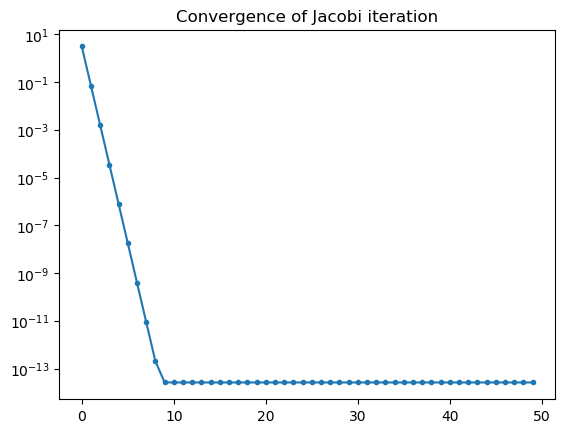

PyObject Text(0.5,1,'Convergence of Jacobi iteration')

In [38]:
m = 20000;
speye(m) = spdiagm(0=>ones(m))
A = sprandn(m,m,0.001) + m/100*speye(m)
b = ones(m)
dA = diag(A);  # vector of the diagonal values
N = - triu(A,1) - tril(A,-1);
x = 0*b;
normres = [];
for k = 1:50
    x = (N*x + b)./dA;
    normres = [normres;norm(b-A*x)];
end
semilogy(normres,".-");
title("Convergence of Jacobi iteration")

Iterative methods come at a price: the convergence of the method depends very strongly on the matrix $A$, as well as the method chosen. Unlike LU factorization and the related direct methods, these methods are far from "plug-and-play." 

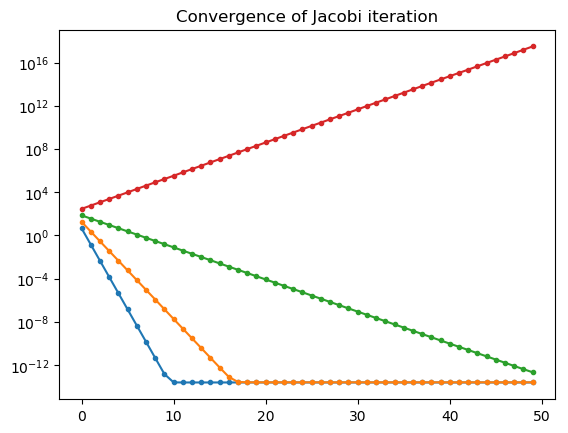

PyObject Text(0.5,1,'Convergence of Jacobi iteration')

In [39]:
mu = sqrt(m);
for i = 1:4
    A = sprandn(m,m,0.001) + mu*speye(m);
    dA = diag(A);
    N = - triu(A,1) - tril(A,-1);
    x = 0*b;
    normres = [];
    for k = 1:50
        x = (N*x + b)./dA;
        normres = [normres;norm(b-A*x)];
    end
    semilogy(normres,".-")
    mu = mu/4;
end
title("Convergence of Jacobi iteration")

Although Jacobi, Gauss-Seidel, and friends are historically important and still helpful in limited circumstances, they have mostly been overtaken by **Krylov subspace methods**. These are more robust over a wider range of problems. Moreover, they allow the incorporation of partial knowledge of the matrix or crude approximate solutions, and they can be used without even needing to know the matrix $A$! This last part sounds strange but is extremely important. 

## Matrix-free iterations

A matrix is the expression of a linear transformation on vectors. Krylov subspace methods require the matrix $A$ only in the form, "find $Av$ given any vector $v$." That is, any representation of the linear transformation is just as good as having the matrix. 

For instance, consider the PageRank algorithm that made Google the king of the internet search. PageRank represents the web as an undirected graph, or equivalently as a weighted adjacency matrix, where adjacency means a link in one page to another. This is an *enormous* graph that is *incredibly* sparse. You don't need to worry about representing the adjacency matrix $A$. Instead, you just need the capability to perform the mapping "given the probability of being on every page, follow links randomly to calculate the probabilities of visiting every page next." 

In differential equations, we don't need a matrix representation of a discretized differentiation operator, which could be a headache on 2D or 3D regions. You just need the operation (for example), "find the values of the derivative of an interpolant to these values." This matrix-free viewpoint is often easier to code and faster to compute. 